In [171]:
import h5py
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from tqdm import tqdm

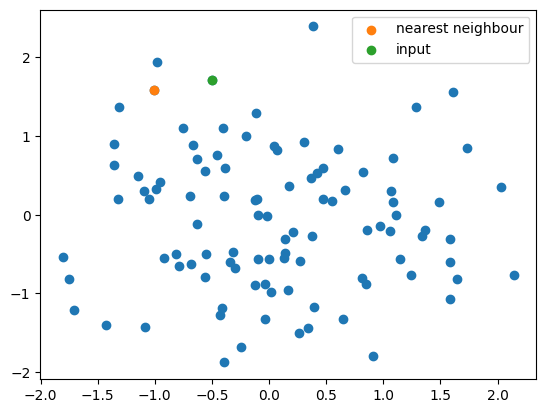

In [83]:
example_f = np.random.randn(100, 2)
example_f_one_nn = example_f[cKDTree(example_f).query(example_f[0], k=2)[1]][1]
plt.scatter(*example_f.T)
plt.scatter(*example_f_one_nn, label="nearest neighbour")
plt.scatter(*example_f[0].T, label="input")
plt.legend()

In [84]:
example_f_augment = np.zeros_like(example_f)

In [95]:
l = 0.5  # Following https://arxiv.org/pdf/1702.05538.pdf
for i in range(len(example_f)):
    _nn = example_f[cKDTree(example_f).query(example_f[i], k=2)[1]][1]
    extrapolated = l * (_nn - example_f[i]) + example_f[i]
    example_f_augment[i] = extrapolated

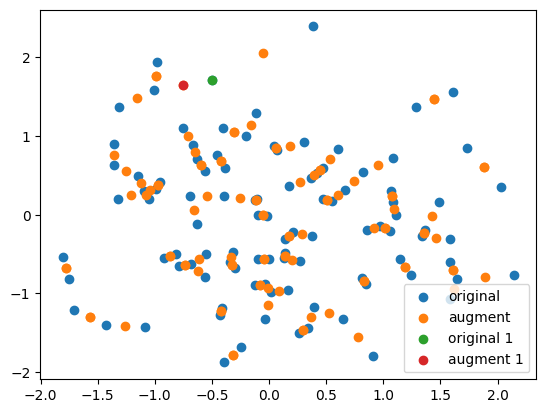

In [96]:
plt.scatter(*example_f.T, label="original")
plt.scatter(*example_f_augment.T, label="augment")
plt.scatter(*example_f[0].T, label="original 1")
plt.scatter(*example_f_augment[0].T, label="augment 1")
plt.legend()
plt.show()

Now, let's do this for all images in the feature vector file.

First, we create a virtual dataset, linking all features to one virtual dataset such that nearest neighbours can be found also between images.

In [163]:
# Find the shape the virtual dataset needs.

filename = "/home/sdejong/pmchhg/features/imagenet-21-4-2023.hdf5"

f = h5py.File(filename)

counter = 0
number_of_features = 0
for i, case_id in enumerate(f.keys()):
    for j, image_id in enumerate(f[case_id].keys()):
        data = f[f"{case_id}/{image_id}/data"]
        number_of_features += data.shape[0]
        counter += 1

print("There are a total of", counter, "datasets")
print("There are a total of", number_of_features, "features")

layout = h5py.VirtualLayout(shape=(759797, 1024), dtype=np.float32)

start = 0
for i, case_id in enumerate(f.keys()):
    for j, image_id in enumerate(f[case_id].keys()):
        data = f[f"{case_id}/{image_id}/data"]
        end = start + data.shape[0]
        vsource = h5py.VirtualSource(data)
        layout[start:end] = vsource

with h5py.File("outputs/10/VDS.h5", 'w', libver='latest') as vds_f:
    vds_f.create_virtual_dataset('data', layout)

There are a total of 134 datasets
There are a total of 759797 features


In [172]:
with h5py.File("outputs/10/VDS.h5", 'r', libver='latest') as vds_f:
    data = vds_f["data"][()]

    data_augment = np.zeros_like(data)

    l = 0.5  # Following https://arxiv.org/pdf/1702.05538.pdf
    for i in tqdm(range(len(example_f)), total=len(example_f)):
        _nn = data[cKDTree(data).query(data[i], k=2, workers=10)[1]][1]  # k=2, because nn for k=1 is the same vector.
        extrapolated = l * (_nn - data[i]) + data[i]
        data_augment[i] = extrapolated

100%|██████████| 100/100 [06:34<00:00,  3.94s/it]


In [173]:
f = h5py.File(filename)
f_augment = h5py.File("/home/sdejong/pmchhg/features/imagenet-21-4-2023-augment.hdf5", "w")
vds_f = h5py.File("outputs/10/VDS.h5", 'r')

all_data = vds_f["data"][()]

start = 0
for i, case_id in enumerate(f.keys()):
    for j, image_id in enumerate(f[case_id].keys()):
        data = f[f"{case_id}/{image_id}/data"]
        end = start + data.shape[0]
        f_augment.create_dataset(f"{case_id}/{image_id}/data", data=all_data[start:end])

f.close()
f_augment.close()
vds_f.close()